In [1]:
import pandas as pd
import numpy as np
import openpyxl
import seaborn as sns
import matplotlib.pyplot as plt

In [78]:
# Cross-sectional GSS data processing
# Load GSS overall data
gss = pd.read_excel("data/GSS.xlsx")

In [79]:
gss.shape

(29189, 119)

In [80]:
pd.set_option('display.max_columns', None)
gss.head(2)

,year,id_,wrkstat,hrs1,hrs2,wrkslf,occ10,indus10,marital,divorce,sphrs2,spocc10,spind10,sibs,childs,age,educ,speduc,degree,sex,race,reg16,mobile16,family16,famdif16,born,income,rincome,region,partyid,polviews,natenvir,natheal,natcity,natcrime,natdrug,nateduc,natrace,natarms,natfare,natsoc,spkath,libath,spkrac,spkcom,libcom,spkhomo,libhomo,cappun,gunlaw,courts,grass,relig,fund,reliten,postlife,bible,racmar,racseg,racopen,busing,happy,hapmar,health,life,helpful,trust,satjob,richwork,class_,satfin,finalter,finrela,fehome,fework,fepres,abdefect,abnomore,abhlth,abpoor,abrape,absingle,abany,chldidel,premarsx,homosex,pornlaw,letdie1,suicide1,owngun,rowngun,news,tvhours,racdif1,racdif2,racdif3,racdif4,helppoor,helpnot,helpsick,helpblk,givhmlss,volchrty,stress,big5a1,big5b1,big5c1,big5d1,big5e1,big5a2,big5b2,big5c2,big5d2,big5e2,commun,cohort,ballot,wtssps,wtssnrps
0,2006,1,Working full time,35,.i: Inapplicable,Someone else,"Nursing, psychiatric, and home health aides",Nursing care facilities,Never married,.i: Inapplicable,.i: Inapplicable,.i: Inapplicable,.i: Inapplicable,1,3,50,1 year of college,.i: Inapplicable,High school,FEMALE,Black,Foreign,Different state,Both own parents,.i: Inapplicable,NO,"$25,000 or more",$25000 OR MORE,Middle Atlantic,Strong democrat,Extremely liberal,TOO LITTLE,ABOUT RIGHT,TOO LITTLE,TOO MUCH,TOO MUCH,ABOUT RIGHT,TOO LITTLE,TOO MUCH,TOO MUCH,TOO LITTLE,ALLOWED,NOT REMOVE,NOT ALLOWED,NOT ALLOWED,REMOVE,NOT ALLOWED,NOT REMOVE,FAVOR,OPPOSE,Not harshly enough,Should not be legal,NaN,Liberal,No religion,YES,Word of god,.i: Inapplicable,.i: Inapplicable,Second law,.i: Inapplicable,Pretty happy,.i: Inapplicable,Fair,Routine,Looking out for themselves,Can't be too careful,Very satisfied,Continue to work,Working class,More or less satisfied,Worse,AVERAGE,.i: Inapplicable,.i: Inapplicable,.i: Inapplicable,YES,.d: Do not Know/Cannot Choose,YES,NO,NO,NO,YES,.i: Inapplicable,.i: Inapplicable,ALWAYS WRONG,There should be laws against the distribution ...,.i: Inapplicable,.i: Inapplicable,NO,.i: Inapplicable,.i: Inapplicable,.i: Inapplicable,.i: Inapplicable,.i: Inapplicable,.i: Inapplicable,.i: Inapplicable,GOVT ACTION,Government should do more,GOVT SHOULD HELP,.d: Do not Know/Cannot Choose,.i: Inapplicable,.i: Inapplicable,Never,.i: Inapplicable,.i: Inapplicable,.i: Inapplicable,.i: Inapplicable,.i: Inapplicable,.i: Inapplicable,.i: Inapplicable,.i: Inapplicable,.i: Inapplicable,.i: Inapplicable,.i: Inapplicable,1956,Ballot c,0.505483,0.524713
1,2006,2,Working full time,40,.i: Inapplicable,Someone else,"First-line supervisors of mechanics, installer...","Alcoholic beverages, merchant wholesalers",Never married,.i: Inapplicable,.i: Inapplicable,.i: Inapplicable,.i: Inapplicable,5,1,27,2 years of college,.i: Inapplicable,High school,MALE,Other,Middle Atlantic,"Same state, same city",Both own parents,.i: Inapplicable,NO,"$25,000 or more",$25000 OR MORE,Middle Atlantic,"Independent, close to republican",Slightly liberal,.i: Inapplicable,.i: Inapplicable,.i: Inapplicable,.i: Inapplicable,.i: Inapplicable,.i: Inapplicable,.i: Inapplicable,.i: Inapplicable,.i: Inapplicable,TOO LITTLE,.i: Inapplicable,.i: Inapplicable,.i: Inapplicable,.i: Inapplicable,.i: Inapplicable,.i: Inapplicable,.i: Inapplicable,FAVOR,.i: Inapplicable,Too harshly,Should not be legal,Catholic,Moderate,Not very strong,.d: Do not Know/Cannot Choose,.d: Do not Know/Cannot Choose,.i: Inapplicable,.i: Inapplicable,.i: Inapplicable,.i: Inapplicable,Very happy,.i: Inapplicable,.i: Inapplicable,.i: Inapplicable,Looking out for themselves,Can't be too careful,Very satisfied,.i: Inapplicable,Working class,More or less satisfied,Better,AVERAGE,.i: Inapplicable,.i: Inapplicable,.i: Inapplicable,.i: Inapplicable,.i: Inapplicable,.i: Inapplicable,.i: Inapplicable,.i: Inapplicable,.i: Inapplicable,.i: Inapplicable,3,NOT WRONG AT ALL,.i: Inapplicable,There should be laws against the distribution ...,YES,NO,.i: Inapplicable,.i: Inapplicable,Every day,1,YES,NO,YES,YES,2,Ag

In [81]:
# Create generation column based on birth year
def determine_generation(year):
    if pd.isna(year):
        return None
    elif year.startswith('.'):
        return None
    year = int(year)
    if year <= 1945:
        return "Silent Generation"
    elif 1946 <= year <= 1964:
        return "Baby Boomer"
    elif 1965 <= year <= 1980:
        return "Generation X"
    elif 1981 <= year <= 1996:
        return "Millennial"
    elif 1997 <= year <= 2012:
        return "Generation Z"
    else:
        return "Generation Alpha"

gss['generation'] = gss['cohort'].apply(determine_generation)

In [82]:
# Remove rows with missing values or values starting with "." in key columns
key_columns = ['year', 'partyid', 'sex', 'race', 'generation', 'degree', 'relig', 'polviews']
gss_cleaned = gss.dropna(subset=key_columns)
for col in key_columns:
    gss_cleaned = gss_cleaned[~gss_cleaned[col].astype(str).str.startswith('.')]

In [83]:
gss_cleaned['generation'].value_counts()

generation
Baby Boomer          6817
Generation X         5099
Millennial           3415
Silent Generation    3153
Generation Z          336
Name: count, dtype: int64

In [84]:
# Mapping
gss_maps = {
    'race': {
        "White": "White person",
        "Black": "Black person", 
        "Other": "person of different race than Black or White" 
    },
    'sex': {
        "Male": "man", 
        "Female": "woman"
    },
    'partyid': {
        "Strong democrat" : "Strong Democrat",
        "Not very strong democrat" : "Democrat",
        "Independent, close to democrat" : "Independent leaning Democrat",
        "Independent (neither, no response)" : "Political Independent",
        "Independent, close to republican" : "Independent leaning Republican",
        "Not very strong republican" : "Republican",
        "Strong republican" : "Strong Republican",
        "Other party" : "Other"
    },
    'wrkstat': {
        "Working full time" : "person working full-time",
        "Working part time" : "person working part-time",
        "Retired" : "retired person",
        "In school" : "student",
        "Unemployed, laid off, looking for work" : "unemployed person",
        "Keeping house" : "homemaker",
        "With a job, but not at work because of temporary illness, vacation, strike" : "person with a job but not at work",
        "Other" : "other"
    },
    'degree': {
        "Less than high school" : "person with less than high school education",
        "High school" : "high school graduate",
        "Associate/junior college" : "person with some college education",
        "Bachelor's" : "person with a bachelor's degree",
        "Graduate" : "person with a graduate degree"
    },
    'relig': {
        "Protestant" : "Protestant",
        "Catholic" : "Catholic",
        "Jewish" : "Jewish",
        "Buddhism" : "person of other religion",
        "Muslim/islam" : "person of other religion",
        "Christian" : "person of other religion",
        "Hinduism" : "person of other religion",
        "Orthodox-christian" : "person of other religion",
        "Inter-nondenominational" : "person of other religion",
        "Native american" : "person of other religion",
        "Other eastern religions" : "person of other religion",
        "Other" : "person of other religion"
    },
    'polviews': {
        "Extremely conservative" : "person with an extremely conservative political view",
        "Conservative" : "person with a conservative political view",
        "Slightly conservative" : "person with a slightly conservative political view",
        "Moderate, middle of the road" : "person with a neutral political view",
        "Slightly liberal" : "person with a slightly liberal political view",
        "Liberal" : "person with a liberal political view",
        "Extremely liberal" : "person with an extremely liberal political view"
    },
    'generation': {
        "Silent Generation" : "person from the Silent Generation",
        "Baby Boomer" : "Baby Boomer",
        "Generation X" : "person from Generation X",
        "Millennial" : "Millennial",
        "Generation Z" : "person from Generation Z",
    }
}

In [85]:
# Create a contextualizer

neutral_scenarios = [
    {
        "q": "Describe your morning routine.",
        "a": "I woke up, brushed my teeth, and had a cup of coffee before checking the news."
    },
    {
        "q": "What are you having for lunch?",
        "a": "I'm planning to have a sandwich and a salad at a local cafe."
    },
    {
        "q": "How is the weather today?",
        "a": "It is partly cloudy and a bit brisk, but the sun is peeking through."
    },
    {
        "q": "What are your plans for the weekend?",
        "a": "I plan to relax at home, catch up on some reading, and maybe go for a walk."
    },
    {
        "q": "Describe your commute.",
        "a": "I traveled to the city center and listened to a podcast on the way."
    }
]

In [86]:
# Create a generator function

def create_contrastive_dataset(demographic_label, baseline_label="person"):

    """
    Generates a list of (X+ and X-) pairs for a specific trait.
    """

    dataset = []

    for scen in neutral_scenarios:
        # X+ example: "[INST] You are a Black person. Describe your morning routine. [/INST] I woke up..."
        pos_prompt = f"[INST] You are a (an) {demographic_label} living in the United States. {scen['q']} [/INST] {scen['a']}"

        # X- example: "[INST] You are a person. Describe your morning routine. [/INST] I woke up..."
        neg_prompt = f"[INST] You are a (an) {baseline_label} living in the United States. {scen['q']} [/INST] {scen['a']}"

        dataset.append((pos_prompt, neg_prompt))
    
    return dataset

In [87]:
# Generate prompts for unique groups
extraction_datasets = {}

# Race
unique_races = gss_cleaned['race'].unique()
for r_code in unique_races:
    trait_text = gss_maps['race'].get(r_code, "person")

    # Generate the dataset for this specific race
    pairs = create_contrastive_dataset(trait_text, baseline_label="person")
    extraction_datasets[f"Race_{trait_text}"] = pairs

# Party ID
unique_parties = gss_cleaned['partyid'].unique()
for p_code in unique_parties:
    trait_text = gss_maps['partyid'].get(p_code, "voter")

    # Generate the dataset for this specific party ID
    pairs = create_contrastive_dataset(trait_text, baseline_label="voter")
    extraction_datasets[f"PartyID_{trait_text}"] = pairs

# Sex
unique_sexes = gss_cleaned['sex'].unique()
for s_code in unique_sexes:
    trait_text = gss_maps['sex'].get(s_code, "person")

    # Generate the dataset for this specific sex
    pairs = create_contrastive_dataset(trait_text, baseline_label="person")
    extraction_datasets[f"Sex_{trait_text}"] = pairs

# Degree
unique_degrees = gss_cleaned['degree'].unique()
for d_code in unique_degrees:
    trait_text = gss_maps['degree'].get(d_code, "person")

    # Generate the dataset for this specific degree
    pairs = create_contrastive_dataset(trait_text, baseline_label="person")
    extraction_datasets[f"Degree_{trait_text}"] = pairs

# Religion
unique_religions = gss_cleaned['relig'].unique()
for r_code in unique_religions:
    trait_text = gss_maps['relig'].get(r_code, "person")

    # Generate the dataset for this specific religion
    pairs = create_contrastive_dataset(trait_text, baseline_label="person")
    extraction_datasets[f"Religion_{trait_text}"] = pairs

# Political Views
unique_pviews = gss_cleaned['polviews'].unique()
for pv_code in unique_pviews:
    trait_text = gss_maps['polviews'].get(pv_code, "person")

    # Generate the dataset for this specific political view
    pairs = create_contrastive_dataset(trait_text, baseline_label="person")
    extraction_datasets[f"PolViews_{trait_text}"] = pairs

# Generation
unique_genviews = gss_cleaned['generation'].unique()
for gen_code in unique_genviews:
    trait_text = gss_maps['generation'].get(gen_code, "person")

    # Generate the dataset for this specific generation
    pairs = create_contrastive_dataset(trait_text, baseline_label="person")
    extraction_datasets[f"Generation_{trait_text}"] = pairs

In [130]:
34*33/2

561.0

In [88]:
len(extraction_datasets)

33

In [127]:
target_key = "Race_Black person"
if target_key in extraction_datasets:
    print(f"--- Prompts generated for '{target_key}' ---")
    for i, (pos, neg) in enumerate(extraction_datasets[target_key]):
        print(f"\nPair {i+1}:")
        print(f"  X+ (Target): {pos}")
        print(f"  X- (Generic):{neg}")

--- Prompts generated for 'Race_Black person' ---

Pair 1:
  X+ (Target): [INST] You are a (an) Black person living in the United States. Describe your morning routine. [/INST] I woke up, brushed my teeth, and had a cup of coffee before checking the news.
  X- (Generic):[INST] You are a (an) person living in the United States. Describe your morning routine. [/INST] I woke up, brushed my teeth, and had a cup of coffee before checking the news.

Pair 2:
  X+ (Target): [INST] You are a (an) Black person living in the United States. What are you having for lunch? [/INST] I'm planning to have a sandwich and a salad at a local cafe.
  X- (Generic):[INST] You are a (an) person living in the United States. What are you having for lunch? [/INST] I'm planning to have a sandwich and a salad at a local cafe.

Pair 3:
  X+ (Target): [INST] You are a (an) Black person living in the United States. How is the weather today? [/INST] It is partly cloudy and a bit brisk, but the sun is peeking through.
 

In [90]:
# Save the extraction datasets to a JSON file
import json
with open("data/gss_extraction_datasets.json", "w") as f:
    json.dump(extraction_datasets, f, indent=4)

In [91]:
# Calculate correlations between different demographic traits
correlation_matrix = gss_cleaned[key_columns].apply(lambda x: pd.factorize(x)[0]).corr()
correlation_matrix

,year,partyid,sex,race,generation,degree,relig,polviews
year,1.000000,-0.021777,-0.011182,0.007826,0.160731,0.083950,0.053180,0.010244
partyid,-0.021777,1.000000,-0.040954,-0.129356,-0.009093,-0.001386,-0.007151,0.013439
sex,-0.011182,-0.040954,1.000000,0.052301,-0.015391,0.002985,-0.012851,0.003608
race,0.007826,-0.129356,0.052301,1.000000,0.014431,-0.038074,-0.013153,0.012347
generation,0.160731,-0.009093,-0.015391,0.014431,1.000000,-0.054107,0.047545,-0.007163
degree,0.083950,-0.001386,0.002985,-0.038074,-0.054107,1.000000,0.078580,-0.048186
relig,0.053180,-0.007151,-0.012851,-0.013153,0.047545,0.078580,1.000000,-0.009095
polviews,0.010244,0.013439,0.003608,0.012347,-0.007163,-0.048186,-0.009095,1.000000


In [97]:
gss_cleaned[key_columns].iloc[:30,:].to_csv("data/gss_cleaned.csv", index=False)

In [94]:
key_columns

['year', 'partyid', 'sex', 'race', 'generation', 'degree', 'relig', 'polviews']

In [96]:
df = gss_cleaned[key_columns].copy()

# Identify interesting pairs

In [102]:

# 1. SETUP# 1. LOAD AND PREPROCESS
df = gss_cleaned[key_columns].copy()
# Drop column 'year'
df = df.drop(columns=['year'])
print(f"Loaded {len(df)} rows.")

# 2. THE "SPECIFIC" CORRELATION MATRIX (The Holy Grail)
# Convert every category into a binary column.
df_encoded = pd.get_dummies(df, columns=['partyid', 'sex', 'race', 'generation', 'degree', 'relig', 'polviews'])

# Calculate the Correlation Matrix (Phi Coefficient for binary data)
# Range: -1 (Perfectly Opposed) to +1 (Perfectly Aligned)
corr_matrix = df_encoded.corr()

def get_top_correlations(corr_matrix, n=10):
    # 1. Unstack the matrix to get long format (Pair A, Pair B, Value)
    au_corr = corr_matrix.abs().unstack()
    
    # 2. Sort by magnitude (Absolute value) to find strongest signals
    pairs = au_corr.sort_values(ascending=False)
    
    # 3. Filter out "Self" correlations (Always 1.0)
    pairs = pairs[pairs < 0.9999]
    
    # 4. Filter out "Intra-Category" correlations
    # (e.g. "race_Black" vs "race_White" is naturally negative, not interesting)
    unique_pairs = []
    seen_pairs = set()
    
    for index, val in pairs.items():
        a, b = index
        
        # Avoid duplicates (A-B is same as B-A)
        if (b, a) in seen_pairs:
            continue
        
        # Extract category prefixes (e.g., "race", "partyid")
        cat_a = a.split('_')[0]
        cat_b = b.split('_')[0]
        
        # SKIP if they are the same category (e.g. Party vs Party)
        if cat_a == cat_b:
            continue
            
        seen_pairs.add((a, b))
        
        # Retrieve the ACTUAL (signed) correlation from the original matrix
        real_corr = corr_matrix.loc[a, b]
        unique_pairs.append((a, b, real_corr))
    
    # Convert to DataFrame
    df_pairs = pd.DataFrame(unique_pairs, columns=['Var1', 'Var2', 'Correlation'])
    return df_pairs


# 2. RUN EXTRACTION
all_pairs = get_top_correlations(corr_matrix, n=1000)

# A. Top POSITIVE Correlations (Aligned Groups)
top_pos = all_pairs[all_pairs['Correlation'] > 0].head(10)

# B. Top NEGATIVE Correlations (Opposing Groups)
top_neg = all_pairs[all_pairs['Correlation'] < 0].head(10)

# C. Top "ZERO" Correlations (The Control Group)
# We look for absolute correlations closest to 0
near_zero = all_pairs[all_pairs['Correlation'].abs() < 0.02].head(10)


# 3. DISPLAY RESULTS
print("--- TOP 10 POSITIVE GSS RELATIONS (Test these for High Similarity) ---")
print(top_pos[['Var1', 'Var2', 'Correlation']])

print("\n--- TOP 10 NEGATIVE GSS RELATIONS (Test these for Low Similarity) ---")
print(top_neg[['Var1', 'Var2', 'Correlation']])

print("\n--- CONTROL GROUP (Test these for Zero Similarity) ---")
print(near_zero[['Var1', 'Var2', 'Correlation']])

Loaded 18820 rows.
--- TOP 10 POSITIVE GSS RELATIONS (Test these for High Similarity) ---
                                     Var1  \
0                   polviews_Conservative   
1                 partyid_Strong democrat   
2                 partyid_Strong democrat   
3         polviews_Extremely conservative   
6                          relig_Hinduism   
8                        relig_Protestant   
10                             race_Other   
11  polviews_Moderate, middle of the road   
12                             race_White   
13     partyid_Not very strong republican   

                                          Var2  Correlation  
0                    partyid_Strong republican     0.348656  
1                                   race_Black     0.293426  
2                             polviews_Liberal     0.269041  
3                    partyid_Strong republican     0.240787  
6                                   race_Other     0.213797  
8                                   race_B

In [103]:
# Save all_pairs to CSV
all_pairs.to_csv("data/gss_correlation_pairs.csv", index=False)

In [105]:
all_pairs.head()

,Var1,Var2,Correlation
0,polviews_Conservative,partyid_Strong republican,0.348656
1,partyid_Strong democrat,race_Black,0.293426
2,partyid_Strong democrat,polviews_Liberal,0.269041
3,polviews_Extremely conservative,partyid_Strong republican,0.240787
4,relig_Protestant,race_Other,-0.223643


In [ ]:
# Load LLM similarity results obtained from Colab (1_extract_persona_vectors.ipynb)
df_llm_pairs = pd.read_csv("data/demo_vectors_similarity_results.csv")

In [107]:
df_llm_pairs.head()

,Var1,Var2,llm_sim
0,polviews_Conservative,partyid_Strong republican,0.597066
1,partyid_Strong democrat,race_Black,0.307786
2,partyid_Strong democrat,polviews_Liberal,0.539885
3,polviews_Extremely conservative,partyid_Strong republican,0.620690
4,relig_Protestant,race_Black,-0.219965


In [108]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress, pearsonr


# 1. PREPARE THE DATA (Load your DFs here)
df_gss = pd.concat([top_pos, top_neg, near_zero]).drop_duplicates()
df_llm = df_llm_pairs.copy()  

# Rename columns to ensure this has columns: Var1, Var2, Correlation
df_llm = df_llm.rename(columns={
    'Var1': 'Var1',
    'Var2': 'Var2',
    'llm_sim': 'Correlation'
})

# --- SAFEGUARD: Clean formatting ---
# Ensure all names are strings and strip whitespace to prevent mismatch
for df in [df_gss, df_llm]:
    df['Var1'] = df['Var1'].astype(str).str.strip()
    df['Var2'] = df['Var2'].astype(str).str.strip()


# 2. CREATE A UNIVERSAL MERGE KEY
# To ensure that "Black x Democrat" matches "Democrat x Black".

def create_pair_key(row):
    # Sort the two variables alphabetically and join them
    return " -- ".join(sorted([row['Var1'], row['Var2']]))

df_gss['pair_id'] = df_gss.apply(create_pair_key, axis=1)
df_llm['pair_id'] = df_llm.apply(create_pair_key, axis=1)


# 3. MERGE THE DATAFRAMES
# Inner merge: only keep pairs that exist in BOTH datasets.
df_final = pd.merge(
    df_gss[['pair_id', 'Correlation']], 
    df_llm[['pair_id', 'Correlation']], 
    on='pair_id', 
    suffixes=('_Real', '_AI')
)

# Rename columns for clarity
df_final = df_final.rename(columns={
    'Correlation_Real': 'GSS_Correlation',
    'Correlation_AI': 'LLM_Similarity'
})

print(f"Successfully aligned {len(df_final)} pairs.")

# Optional: Print the first few rows to verify
print(df_final.head())


# 4. STATISTICAL ANALYSIS

if len(df_final) > 2:
    # 1. Pearson Correlation (How well does the AI track reality?)
    r_val, p_val = pearsonr(df_final['GSS_Correlation'], df_final['LLM_Similarity'])
    
    # 2. Linear Regression (Does the AI exaggerate?)
    slope, intercept, _, _, std_err = linregress(df_final['GSS_Correlation'], df_final['LLM_Similarity'])
    
    print("\n--- STATISTICAL RESULTS ---")
    print(f"Alignment Correlation (r): {r_val:.4f} (Target: > 0.5)")
    print(f"P-value:                   {p_val:.4e}")
    print(f"Amplification Slope:       {slope:.4f}")
    
    if slope > 1.1:
        print(">> INTERPRETATION: Stereotype Amplification (Model exaggerates trends)")
    elif slope < 0.9:
        print(">> INTERPRETATION: Stereotype Dampening (Model suppresses trends)")
    else:
        print(">> INTERPRETATION: Perfect Calibration")

Successfully aligned 26 pairs.
                                             pair_id  GSS_Correlation  \
0  partyid_Strong republican -- polviews_Conserva...         0.348656   
1              partyid_Strong democrat -- race_Black         0.293426   
2        partyid_Strong democrat -- polviews_Liberal         0.269041   
3  partyid_Strong republican -- polviews_Extremel...         0.240787   
4                     race_Black -- relig_Protestant         0.193480   

   LLM_Similarity  
0        0.597066  
1        0.307786  
2        0.539885  
3        0.620690  
4       -0.219965  

--- STATISTICAL RESULTS ---
Alignment Correlation (r): 0.7431 (Target: > 0.5)
P-value:                   1.3684e-05
Amplification Slope:       1.3797
>> INTERPRETATION: Stereotype Amplification (Model exaggerates trends)


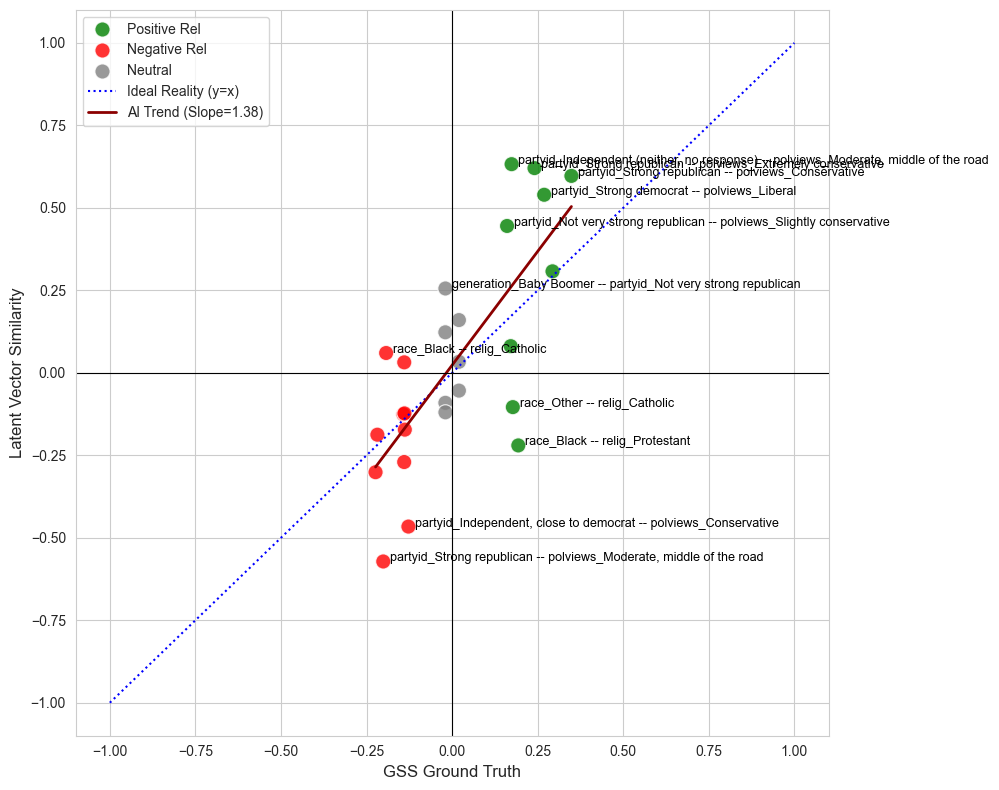

In [113]:
# 5. GENERATE THE PLOT
plt.figure(figsize=(10, 8))
sns.set_style("whitegrid")

# Define categories for coloring (Optional: Positive/Negative/Neutral)
conditions = [
    (df_final['GSS_Correlation'] > 0.1),
    (df_final['GSS_Correlation'] < -0.1)
]
choices = ['Positive Rel', 'Negative Rel']
df_final['Type'] = np.select(conditions, choices, default='Neutral')

# 1. Scatter Plot
sns.scatterplot(
    data=df_final,
    x='GSS_Correlation',
    y='LLM_Similarity',
    hue='Type',
    palette={'Positive Rel': 'green', 'Negative Rel': 'red', 'Neutral': 'gray'},
    s=120, alpha=0.8
)

# 2. Perfect Alignment Line (y=x) - Blue Dotted
plt.plot([-1, 1], [-1, 1], color='blue', linestyle=':', label='Ideal Reality (y=x)')

# 3. Actual Regression Line - Red Solid
if len(df_final) > 2:
    x_range = np.array([df_final['GSS_Correlation'].min(), df_final['GSS_Correlation'].max()])
    y_pred = intercept + slope * x_range
    plt.plot(x_range, y_pred, color='darkred', linewidth=2, label=f'AI Trend (Slope={slope:.2f})')

# 4. Labels for outliers
for i in range(len(df_final)):
    # Only label points where there is a significant discrepancy or high correlation
    x_val = df_final['GSS_Correlation'].iloc[i]
    y_val = df_final['LLM_Similarity'].iloc[i]
    label = df_final['pair_id'].iloc[i]
    
    # Logic: Label if correlation is strong OR error is large
    if abs(x_val) > 0.3 or abs(x_val - y_val) > 0.2:
        # shorten label: "race_Black -- partyid_Rep" -> "Black-Rep"
        short_label = label.replace("race_", "").replace("partyid_", "").replace("Strong ", "")
        plt.text(x_val + 0.02, y_val, label, fontsize=9, color='black')


plt.xlabel("GSS Ground Truth", fontsize=12)
plt.ylabel("Latent Vector Similarity", fontsize=12)
plt.axhline(0, color='black', linewidth=0.8)
plt.axvline(0, color='black', linewidth=0.8)
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.legend(loc='upper left')
plt.tight_layout()

plt.show()

--- ROBUSTNESS CHECK ---
Spearman Rank Correlation: 0.6937
>> RESULT: ROBUST. The LLM correctly ranks which groups are close/far.

Normalized (Z-Score) Slope: 0.7431
>> REVISED: Stereotype Dampening.
   The previous high slope was just a unit artifact. The model actually compresses differences.


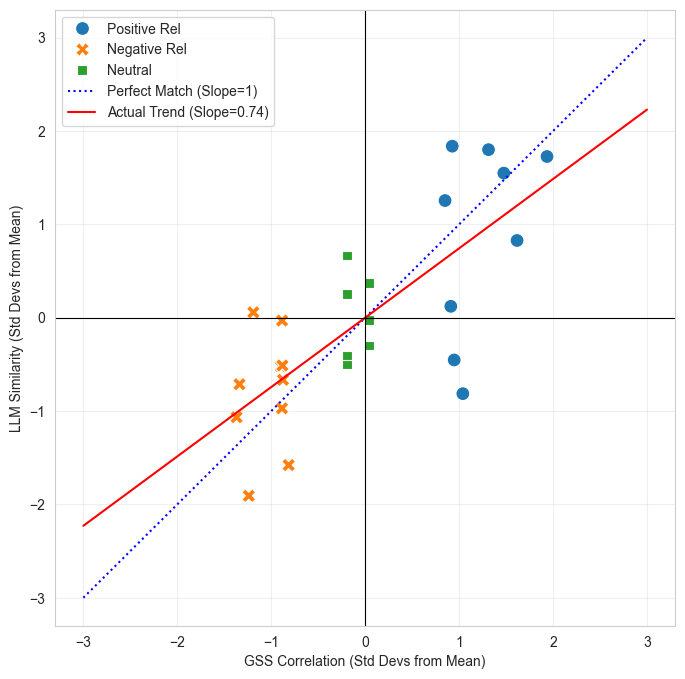

In [116]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming 'df_final' exists from the previous step
# Columns: 'GSS_Correlation', 'LLM_Similarity', 'Type'

print("--- ROBUSTNESS CHECK ---")

# 1. SPEARMAN RANK CORRELATION (Non-Parametric)
# This ignores the specific "units" and checks the ordering.
rho, p_val = stats.spearmanr(df_final['GSS_Correlation'], df_final['LLM_Similarity'])
print(f"Spearman Rank Correlation: {rho:.4f}")

if rho > 0.6:
    print(">> RESULT: ROBUST. The LLM correctly ranks which groups are close/far.")
else:
    print(">> RESULT: WEAK. The ordering is scrambled, even if the line looks okay.")

# 2. Z-SCORE NORMALIZATION (Standardizing the Scales)
# We subtract the mean and divide by std dev for both axes.
df_final['GSS_Z'] = stats.zscore(df_final['GSS_Correlation'])
df_final['LLM_Z'] = stats.zscore(df_final['LLM_Similarity'])

# 3. CALCULATE NORMALIZED SLOPE
slope_z, intercept_z, r_val_z, _, _ = stats.linregress(df_final['GSS_Z'], df_final['LLM_Z'])

print(f"\nNormalized (Z-Score) Slope: {slope_z:.4f}")

# Interpretation logic
if slope_z > 1.1:
    print(">> CONFIRMED: Stereotype Amplification.")
    print("   Even after correcting for scale, the LLM makes distinct groups MORE distinct than reality.")
elif slope_z < 0.9:
    print(">> REVISED: Stereotype Dampening.")
    print("   The previous high slope was just a unit artifact. The model actually compresses differences.")
else:
    print(">> REVISED: Perfect Alignment.")
    print("   The model reflects the relative intensity of real-world links accurately.")

# 4. PLOT THE NORMALIZED VERSION
plt.figure(figsize=(8, 8))
sns.scatterplot(
    data=df_final, x='GSS_Z', y='LLM_Z', 
    hue='Type', style='Type', s=100
)
plt.plot([-3, 3], [-3, 3], 'b:', label="Perfect Match (Slope=1)")
x_range = np.array([-3, 3])
plt.plot(x_range, intercept_z + slope_z * x_range, 'r-', label=f"Actual Trend (Slope={slope_z:.2f})")
plt.axhline(0, color='black', linewidth=0.8)
plt.axvline(0, color='black', linewidth=0.8)

plt.xlabel("GSS Correlation (Std Devs from Mean)")
plt.ylabel("LLM Similarity (Std Devs from Mean)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Calculate Phi Coefficients for GSS Dataset

In [ ]:
# 1. LOAD AND PREPROCESS
df = gss_cleaned[key_columns].copy()
print(f"Loaded {len(df)} rows.")

# 2. THE "SPECIFIC" CORRELATION MATRIX (The Holy Grail)
# Convert every category into a binary column.
df_encoded = pd.get_dummies(df, columns=['partyid', 'sex', 'race', 'generation', 'degree', 'relig', 'polviews'])

# Calculate the Correlation Matrix (Phi Coefficient for binary data)
# Range: -1 (Perfectly Opposed) to +1 (Perfectly Aligned)
corr_matrix = df_encoded.corr()

# 3. EXTRACTING SPECIFIC PAIRS FOR COMPARISON
# The same pairs calculated in your LLM experiment
# Note: Must match the column names generated by get_dummies
pairs_to_check = [
    ('race_Black', 'partyid_Strong democrat'),
    ('race_Black', 'partyid_Strong republican'),
    ('sex_FEMALE', 'partyid_Strong democrat'),
    ('relig_Catholic', 'polviews_Conservative'),
    ('degree_Bachelor\'s', 'polviews_Liberal') 
]

print("\n--- GSS Real-World Correlations (Ground Truth) ---")
print(f"{'Pair':<50} | {'Correlation (Phi)':<10}")
print("-" * 70)

real_world_stats = {}

for item_a, item_b in pairs_to_check:
    # Check if columns exist (in case the sample data didn't have them)
    if item_a in corr_matrix.columns and item_b in corr_matrix.columns:
        corr_val = corr_matrix.loc[item_a, item_b]
        real_world_stats[f"{item_a} x {item_b}"] = corr_val
        print(f"{item_a:<25} x {item_b:<25} | {corr_val:+.4f}")
    else:
        print(f"⚠️ {item_a} or {item_b} not found in dataset columns.")

# ==========================================
# 4. VISUALIZATION (Global Heatmap)
# ==========================================
# Let's plot just the Race vs Party interactions to see the landscape
race_cols = [c for c in df_encoded.columns if 'race_' in c]
party_cols = [c for c in df_encoded.columns if 'partyid_' in c]

if race_cols and party_cols:
    subset_corr = corr_matrix.loc[race_cols, party_cols]
    
    plt.figure(figsize=(12, 6))
    sns.heatmap(subset_corr, annot=True, cmap='coolwarm', center=0, fmt='.2f')
    plt.title("GSS Correlation Map: Race vs. Party Identity")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

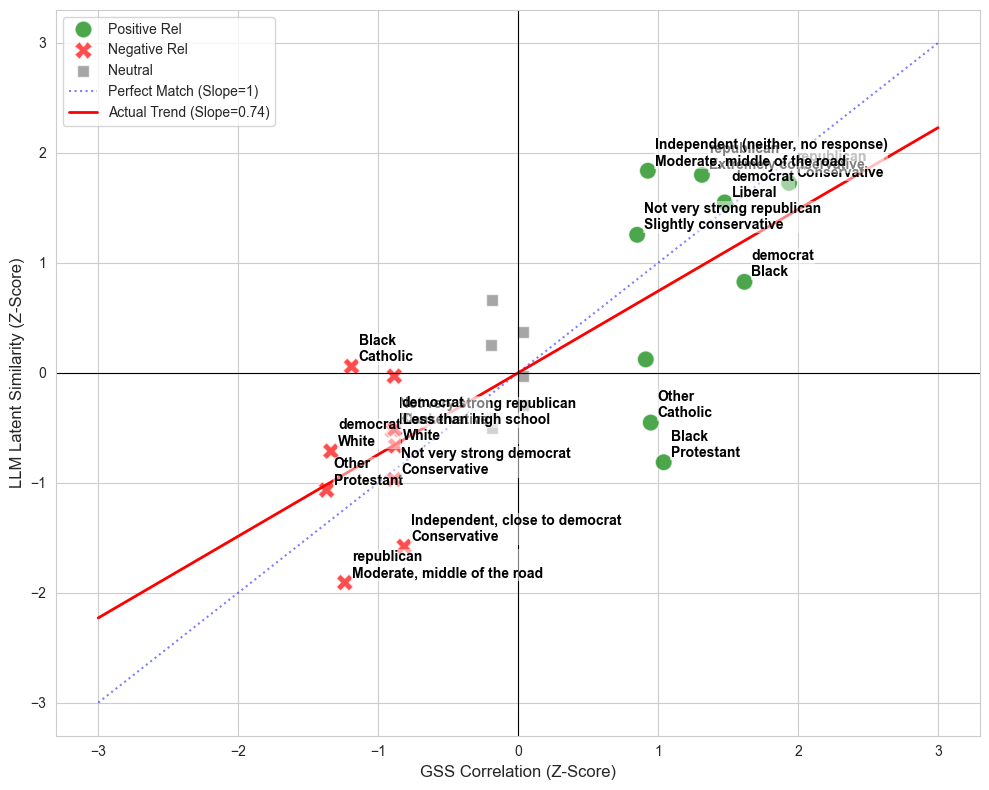

In [122]:
# ==========================================
# 1. HELPER: CLEAN LABELS FOR DISPLAY
# ==========================================
def clean_label(pair_string):
    """
    Shortens 'race_Black -- partyid_Strong Democrat' 
    to 'Black x Democrat' for the plot.
    """
    # Remove common prefixes
    text = pair_string.replace("race_", "").replace("partyid_", "")
    text = text.replace("sex_", "").replace("relig_", "").replace("polviews_", "")
    text = text.replace("degree_", "").replace("generation_", "")
    
    # Remove "Strong" and "person" to save space
    text = text.replace("Strong ", "").replace(" person", "")
    
    # Replace the separator with a shorter symbol
    text = text.replace(" -- ", "\n") # Newline helps stacking
    return text

# ==========================================
# 2. GENERATE PLOT WITH LABELS
# ==========================================
plt.figure(figsize=(10, 8))
sns.set_style("whitegrid")

# Main Scatter Plot
sns.scatterplot(
    data=df_final, 
    x='GSS_Z', 
    y='LLM_Z', 
    hue='Type', 
    style='Type', 
    s=150, # Bigger dots
    palette={'Positive Rel': 'green', 'Negative Rel': 'red', 'Neutral': 'gray'},
    alpha=0.7
)

# Add Reference Lines
plt.plot([-3, 3], [-3, 3], 'b:', alpha=0.5, label="Perfect Match (Slope=1)")
x_range = np.array([-3, 3])
plt.plot(x_range, intercept_z + slope_z * x_range, 'r-', linewidth=2, label=f"Actual Trend (Slope={slope_z:.2f})")

# ADD TEXT LABELS LOOP
for i in range(len(df_final)):
    x_pos = df_final['GSS_Z'].iloc[i]
    y_pos = df_final['LLM_Z'].iloc[i]
    raw_label = df_final['pair_id'].iloc[i]
    
    # 1. Clean the label
    display_label = clean_label(raw_label)
    
    # 2. Add text to plot
    # Logic: Only label points that are statistically significant (far from center)
    # or where the model is making a huge error (large difference between X and Y)
    dist_from_center = np.sqrt(x_pos**2 + y_pos**2)
    
    if dist_from_center > 1.0: # Only label interesting points (Z > 1)
        plt.text(
            x_pos + 0.05,  # Shift X slightly right
            y_pos + 0.05,  # Shift Y slightly up
            display_label, 
            fontsize=10, 
            weight='bold',
            color='black',
            bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', pad=0.5) # Background box for readability
        )

plt.xlabel("GSS Correlation (Z-Score)", fontsize=12)
plt.ylabel("LLM Latent Similarity (Z-Score)", fontsize=12)
plt.axhline(0, color='black', linewidth=0.8)
plt.axvline(0, color='black', linewidth=0.8)
plt.legend(loc='upper left')
plt.tight_layout()

plt.show()